### Purpose and description of this notebook 

In [1]:
from shapely.geometry import Polygon, Point
import geopandas
import numpy as np
import os
import matplotlib.pylab as plt

In [2]:
# Load US ecoregions and plot the united states land mass together
eco_dir = os.path.join("..", "Data", "LandCover", "eco-us-shp")
eco_shp = geopandas.read_file(eco_dir)
print(type(eco_shp))
print(eco_shp.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'proj': 'laea', 'lat_0': 45, 'lon_0': -100, 'x_0': 0, 'y_0': 0, 'a': 6370997, 'b': 6370997, 'units': 'm', 'no_defs': True}


In [3]:
eco_reprojected = eco_shp.to_crs({'init': '+init=epsg:4326'})

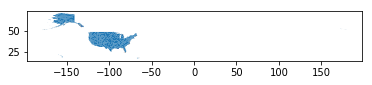

In [4]:
eco_reprojected.plot()

In [5]:
from netCDF4 import Dataset
cmip_dir = os.path.join('..','Data','CMIP5','r1i1p1_rcp45_rcp85_merged_t_COMMON_GRID', 'tas_Amon_NorESM1-M_rcp45_r1i1p1_200601-210012.nc')
cmip = Dataset(cmip_dir,'r')
lat = cmip.variables['lat'][:]
lon = cmip.variables['lon'][:] - 180. # Will be reprojected using CDO
tas = cmip.variables['tas'][:]
cmip.close()

In [6]:
dx = np.unique(np.diff(lon))
print(dx)
dy = np.unique(np.diff(lat))
print(dy)

[2.5]
[2.]


In [7]:
# Make polygons that describe the global grid
grid_polygons = []

for i in range(len(lon)) :
    for j in range(len(lat)) :
        
        x_center = lon[i]
        y_center = lat[j]
        
        x0 = x_center - dx/2.
        x1 = x_center + dx/2.
        y0 = y_center - dy/2.
        y1 = y_center + dy/2.
        
        grid_box_poly = Polygon([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])
        
        grid_polygons.append(grid_box_poly)


grid_geo = geopandas.GeoSeries(grid_polygons)

In [8]:
len(grid_polygons)

12960

In [9]:
# Make a GeoDataFrame
grid_geo_df = geopandas.GeoDataFrame({'geometry':grid_polygons, 'grid_ID': np.arange(len(grid_polygons))})
# CRS projection to assign to grid boxes when made into polygons
crs_to_assign = {'init': '+init=epsg:4326'}
grid_geo_df.crs = crs_to_assign

In [10]:
# Get world land mass file and set to the same crs 
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_df = world.to_crs(crs_to_assign)

<Figure size 600x400 with 0 Axes>

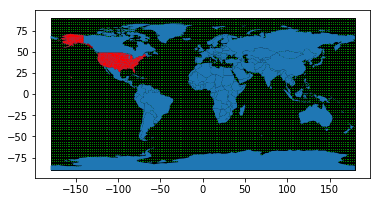

In [11]:
plt.figure(dpi=100)
base = grid_geo_df.plot(edgecolor='black', color="green")
world_df.plot(ax=base)
eco_reprojected.plot(ax=base, color='red')
plt.show()

In [12]:
overlap = geopandas.overlay(grid_geo_df, world_df, how='intersection')
# The grid_ID that show up in overlap are the ones I need to flag as overlapping land. 


In [13]:
overlap.columns

Index(['grid_ID', 'pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est',
       'geometry'],
      dtype='object')

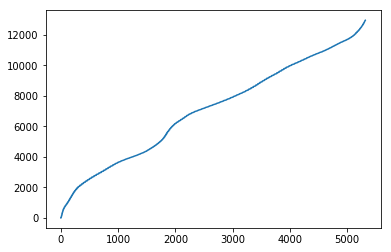

In [14]:
unique_overlapping_grid_IDs = np.unique(np.array(overlap.grid_ID.copy()))
plt.plot(np.sort(unique_overlapping_grid_IDs))

In [15]:
print(len(unique_overlapping_grid_IDs))
print(len(np.unique(unique_overlapping_grid_IDs)))

5322
5322


In [16]:
print(grid_geo_df.columns)
print(world_df.columns)

Index(['geometry', 'grid_ID'], dtype='object')
Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')


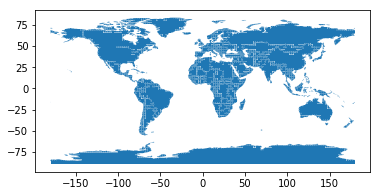

In [17]:
overlap.plot()

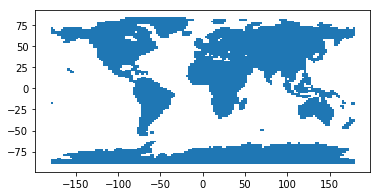

In [18]:
grid_geo_df.iloc[unique_overlapping_grid_IDs,:].plot()

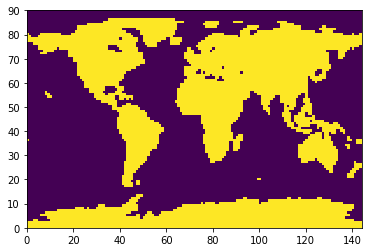

In [19]:
# Translate back to the original lat lon grid 
land_mask = np.zeros((len(lat), len(lon)), dtype=int)
count = 0
for i in range(len(lon)) :
    for j in range(len(lat)) :
        n_in_array = np.sum(count == unique_overlapping_grid_IDs)
        if n_in_array > 0 :
            land_mask[j,i] = 1
        count += 1
        
plt.pcolor(land_mask)

In [20]:
# Write this land mask as a netcdf file 
outputFile = os.path.join("..","Data","LandCover", "land_mask.nc")
outputFileCommonGrid = os.path.join("..","Data","LandCover", "common_grid_land_mask.nc")

ncFile = Dataset(outputFile, 'w', format='NETCDF4')
ncFile.description = 'Land mask according to netcdf grid box overlap with naturalearth_lowres grom geopandas'
ncFile.location = 'Global'
ncFile.createDimension('latitude', len(lat) )
ncFile.createDimension('longitude', len(lon) )

# Create data variables
VAR_ = ncFile.createVariable("land_mask", 'f4',('latitude','longitude'))
VAR_.units = "1=land, 0=not land"

# create lat variable
latitude_ = ncFile.createVariable('latitude', 'f4', ('latitude',))
latitude_.units = 'degrees_north'
latitude_.axis = "Y"

# create longitude variable
longitude_ = ncFile.createVariable('longitude', 'f4', ('longitude',))
longitude_.units = "degrees_east"
longitude_.long_name = "longitude"
longitude_.axis = "X"
#longitude_.lon_bnds = lon_bnds

# Write the actual data to these dimensions
VAR_[:]       = land_mask[:]
latitude_[:]  = np.array(lat)
longitude_[:] = np.array(lon)
ncFile.close()

# And use cdo to make a common grid version 
import cdo as cdo
cdo = cdo.Cdo()

common_grid_file = os.path.join("..","Data","LandCover",'COMMON_GRID.txt')
cdo.remapbil(common_grid_file, input=outputFile, output=outputFileCommonGrid, options="-b F64")

'../Data/LandCover/common_grid_land_mask.nc'

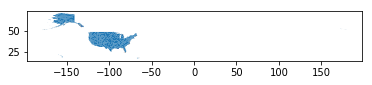

In [21]:
# Read in bailys shapes
bailys_shp = eco_reprojected
bailys_shp.plot()

In [22]:
overlap = geopandas.overlay(grid_geo_df, bailys_shp, how='intersection')

In [23]:
overlap.columns

Index(['grid_ID', 'AREA', 'PERIMETER', 'ECO_US_', 'ECO_US_ID', 'ECOCODE',
       'DOMAIN', 'DIVISION', 'PROVINCE', 'SECTION', 'geometry'],
      dtype='object')

<Figure size 900x600 with 0 Axes>

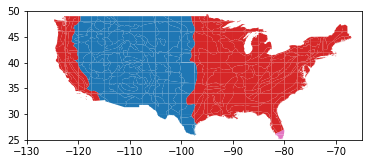

In [24]:
plt.figure(dpi=150)
ax=overlap.plot(column='DOMAIN')
ax.set_xlim(left=-130, right=-65)
ax.set_ylim(bottom=25, top=50)
plt.show()

<Figure size 900x600 with 0 Axes>

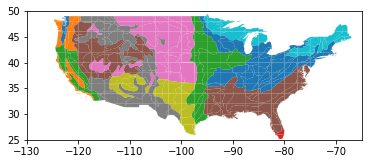

In [25]:
plt.figure(dpi=150)
ax=overlap.plot(column='DIVISION')
ax.set_xlim(left=-130, right=-65)
ax.set_ylim(bottom=25, top=50)
plt.show()

<Figure size 900x600 with 0 Axes>

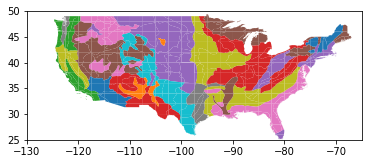

In [26]:
plt.figure(dpi=150)
ax=overlap.plot(column='PROVINCE')
ax.set_xlim(left=-130, right=-65)
ax.set_ylim(bottom=25, top=50)
plt.show()

In [27]:
overlap

,grid_ID,AREA,PERIMETER,ECO_US_,ECO_US_ID,ECOCODE,DOMAIN,DIVISION,PROVINCE,SECTION,geometry
0,4193,2.145620e+08,87928.313,2718,2874,M411A,HUMID TROPICAL DOMAIN,Savanna Regime Mountains,Puerto Rico Province,Dry-Humid Mountains Section,POLYGON ((-64.88556614652482 17.68375648437942...
1,4193,7.266470e+05,4658.706,2717,2873,M411A,HUMID TROPICAL DOMAIN,Savanna Regime Mountains,Puerto Rico Province,Dry-Humid Mountains Section,POLYGON ((-64.62725066426749 17.78725886906634...
2,4103,1.663401e+06,6470.289,2723,2879,M411A,HUMID TROPICAL DOMAIN,Savanna Regime Mountains,Puerto Rico Province,Dry-Humid Mountains Section,POLYGON ((-66.51121867912278 17.90128112397011...
3,954,1.050000e+10,506158.000,2000,2070,M423A,HUMID TROPICAL DOMAIN,Rainforest Regime Mountains,Hawaiian Islands Province,Hawaiian Islands Section,"POLYGON ((-155 19.33643718919651, -155 19.7380..."
4,864,1.050000e+10,506158.000,2000,2070,M423A,HUMID TROPICAL DOMAIN,Rainforest Regime Mountains,Hawaiian Islands Province,Hawaiian Islands Section,"POLYGON ((-155 19.73804387966055, -155 19.3364..."
5,4104,1.643721e+05,1852.643,2716,2872,M411A,HUMID TROPICAL DOMAIN,Savanna Regime Mountains,Puerto Rico Province,Dry-Humid Mountains Section,POLYGON ((-65.60391908876174 18.21400479721379...
6,4104,1.424392e+05,1507.495,2715,2871,M411A,HUMID TROPICAL DOMAIN,Savanna Regime Mountains,Puerto Rico Province,Dry-Humid Mountains Section,"POLYGON ((-65.5765006493381 18.2477351689717, ..."
7,4104,1.318019e+06,6347.154,2714,2870,M411A,HUMID TROPICAL DOMAIN,Savanna Regime Mountains,Puerto Rico Province,Dry-Humid Mountains Section,"POLYGON ((-65.59777080495653 18.2473536035608,..."
8,4194,2.252408e+05,2667.111,2700,2856,M411A,HUMID TROPICAL DOMAIN,Savanna Regime Mountains,Puerto Rico Province,Dry-Humid Mountains Section,"POLYGON ((-64.8936684853102 18.27619306383538,..."
9,4104,1.441820e+06,5129.166,2722,2878,M411A,HUMID TROPICAL DOMAIN,Savanna Regime Mountains,Puerto Rico Province,Dry-Humid Mountains Section,"POLYGON ((-67.4898908827859 18.38560445406271,..."


In [28]:
unique_divisions = np.unique(overlap.DIVISION)

In [29]:
# Store masks that indicate if a grid cell overlaps with a given division
division_dictionary = {}

for division in unique_divisions : 
    
    print("Masking " + division)
    
    # Translate back to the original lat lon grid for a single land cover type
    land_cover_area = np.zeros((len(lat), len(lon)), dtype=int)
    grid_index = 0
    for i in range(len(lon)) :
        for j in range(len(lat)) :

            # Where in over does this grid_index exist?
            in_array = grid_index == np.array(overlap.grid_ID)
            # What of those are the division of interest? 
            division_mask = division == np.array(overlap.DIVISION)        
            m = in_array & division_mask

            if np.sum(m) > 0 :
                land_cover_area[j,i] = 1 #np.sum(overlap.loc[m,'AREA'])

            grid_index += 1
            
    # Assign these values, store in the dictionary
    division_dictionary[division] = land_cover_area


Masking Hot Continental Division
Masking Hot Continental Regime Mountains
Masking Marine Division
Masking Marine Regime Mountains
Masking Mediterranean Division
Masking Mediterranean Regime Mountains
Masking Prairie Division
Masking Rainforest Regime Mountains
Masking Savanna Division
Masking Savanna Regime Mountains
Masking Subarctic Division
Masking Subarctic Regime Mountains
Masking Subtropical Division
Masking Subtropical Regime Mountains
Masking Temperate Desert Division
Masking Temperate Desert Regime Mountains
Masking Temperate Steppe Division
Masking Temperate Steppe Regime Mountains
Masking Tropical/Subtropical Desert Division
Masking Tropical/Subtropical Regime Mountains
Masking Tropical/Subtropical Steppe Division
Masking Tundra Division
Masking Tundra Regime Mountains
Masking Warm Continental Division
Masking Warm Continental Regime Mountains


In [30]:
division_dictionary.keys()

dict_keys(['Hot Continental Division', 'Hot Continental Regime Mountains', 'Marine Division', 'Marine Regime Mountains', 'Mediterranean Division', 'Mediterranean Regime Mountains', 'Prairie Division', 'Rainforest Regime Mountains', 'Savanna Division', 'Savanna Regime Mountains', 'Subarctic Division', 'Subarctic Regime Mountains', 'Subtropical Division', 'Subtropical Regime Mountains', 'Temperate Desert Division', 'Temperate Desert Regime Mountains', 'Temperate Steppe Division', 'Temperate Steppe Regime Mountains', 'Tropical/Subtropical Desert Division', 'Tropical/Subtropical Regime Mountains', 'Tropical/Subtropical Steppe Division', 'Tundra Division', 'Tundra Regime Mountains', 'Warm Continental Division', 'Warm Continental Regime Mountains'])

In [31]:
# Write this land mask as a netcdf file 
outputFile = os.path.join("..","Data","LandCover", "bailys_division_masks.nc")
outputFileCommonGrid = os.path.join("..","Data","LandCover", "bailys_division_masks_common_grid.nc")

ncFile = Dataset(outputFile, 'w', format='NETCDF4')
ncFile.description = 'Bailys Division masks'
ncFile.location = 'Global'
ncFile.createDimension('latitude', len(lat) )
ncFile.createDimension('longitude', len(lon) )

# create lat variable
latitude_ = ncFile.createVariable('latitude', 'f4', ('latitude',))
latitude_.units = 'degrees_north'
latitude_.axis = "Y"

# create longitude variable
longitude_ = ncFile.createVariable('longitude', 'f4', ('longitude',))
longitude_.units = "degrees_east"
longitude_.long_name = "longitude"
longitude_.axis = "X"
#longitude_.lon_bnds = lon_bnds

# Create data variables
for key in division_dictionary.keys() :
    VAR_ = ncFile.createVariable(key, 'f4',('latitude','longitude'))
    VAR_.units = "1=land, 0=not land"
    VAR_[:]    = division_dictionary[key]

latitude_[:]  = np.array(lat)
longitude_[:] = np.array(lon)
ncFile.close()

# And use cdo to make a common grid version 
import cdo as cdo
cdo = cdo.Cdo()

common_grid_file = os.path.join("..","Data","LandCover",'COMMON_GRID.txt')
cdo.remapbil(common_grid_file, input=outputFile, output=outputFileCommonGrid, options="-b F64")

'../Data/LandCover/bailys_division_masks_common_grid.nc'

In [32]:
x=np.array([True,True,False,False])
y=np.array([True,False,True,False])
x & y

array([ True, False, False, False])